In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import diffusion_gnn_main_backup as diffusion_gnn_main
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
! nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-8ca5ef4d-1c36-3581-4632-718ba31be3d8)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-7ae1229d-2111-c957-e3bf-ffd3b8962db8)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-ee14d5dc-27f3-abcd-c21a-5ffae193fc6d)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-716b5ca3-5abd-a70a-5b92-cb062a721d89)


In [4]:
### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
batch_count = 64
batch_size = 32
num_nodes = 1
num_features = 1

diffusion_steps = 10
min_beta = 1e-4
max_beta = 0.2#0.02

checkpoint_path = "training14/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [6]:
diffusion_model = diffusion_gnn_main.DiffusiveGenerativeNetwork(
    num_nodes, diffusion_gnn_main.BetaScheduler(min_beta, max_beta, diffusion_steps), 1, num_features, 128, diffusion_steps)
#diffusion_model = diffusion_gnn_main.DiffusiveGenerativeNetwork(
#    num_nodes, diffusion_gnn_main.BetaScheduler(min_beta, max_beta, diffusion_steps), 8, num_features, 16, diffusion_steps)

In [7]:
def generate_input_data(batch_count, batch_size, num_nodes, num_features):
    return tf.random.normal([batch_count * batch_size, num_nodes, num_features])


def generate_training_data(batch_count, batch_size, num_nodes, num_features):
    return tf.random.normal([batch_count * batch_size, num_nodes, num_features], mean = 0., stddev = 0.5)
    #return tf.random.uniform([batch_count * batch_size, num_nodes, num_features]) + 5.
    #distribution1 = tf.random.normal([batch_count * batch_size // 2, num_nodes, num_features], mean = -3., stddev = 1.)
    #distribution2 = tf.random.normal([batch_count * batch_size // 2, num_nodes, num_features], mean = 3., stddev = 1.)
    #return tf.concat([distribution1, distribution2], axis = 0)

In [18]:
optimizer = keras.optimizers.RMSprop(learning_rate = 5e-6)#2e-5)

In [9]:
# Instantiate an optimizer.
#optimizer = keras.optimizers.Adam(learning_rate = 4e-2)#4e-4)#5e-3)
optimizer = keras.optimizers.RMSprop(learning_rate = 6e-4)

x_train = generate_input_data(batch_count, batch_size, num_nodes, num_features)
y_train = generate_training_data(batch_count, batch_size, num_nodes, num_features)

# Reserve 1000 samples for validation.
validation_count = 1

x_val = x_train[-validation_count:]
y_val = y_train[-validation_count:]
x_train = x_train[:-validation_count]
y_train = y_train[:-validation_count]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_dataset = train_dataset.shuffle(buffer_size = batch_size - validation_count).batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = batch_size).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [10]:
x_batch_train = tf.reshape(x_train, [x_train.shape[0] * x_train.shape[1], x_train.shape[2]])
x_batch_train = diffusion_gnn_main.Graph.generate_fully_connected_graph(x_batch_train, num_nodes, x_batch_train.shape[0])
diffusion_model(x_batch_train)

In [11]:
diffusion_model.denoiser_model.summary()

Model: "gnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  16512     
                                                                 
 layer_normalization (LayerN  multiple                 258       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             multiple                  256       
                                                                 
 gcl (GCL)                   multiple                  49920     
                                                                 
 sequential_1 (Sequential)   (None, 128)               16768     
                                                                 
Total params: 83,714
Trainable params: 83,714
Non-trainable params: 0
___________________________________________________________

In [15]:
#diffusion_model.load_weights("training13/cp-0021.ckpt")
diffusion_model.load_weights("training14/cp-0002.ckpt")

In [19]:
epochs = 500
for epoch in range(epochs):
    # Iterate over the batches of the dataset.
    progress_bar = tf.keras.utils.Progbar(len(train_dataset), stateful_metrics = ['epoch', 'loss'])
    losses = []
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        batch_size_train = x_batch_train.shape[0]
        x_batch_train = tf.reshape(x_batch_train, [x_batch_train.shape[0] * x_batch_train.shape[1], x_batch_train.shape[2]])
        y_batch_train = tf.reshape(y_batch_train, [y_batch_train.shape[0] * y_batch_train.shape[1], y_batch_train.shape[2]])
        x_batch_train = diffusion_gnn_main.Graph.generate_fully_connected_graph(x_batch_train, num_nodes, batch_size_train)
        y_batch_train = diffusion_gnn_main.Graph.generate_fully_connected_graph(y_batch_train, num_nodes, batch_size_train)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = diffusion_model(x_batch_train, training = True)  # Logits for this minibatch
            #print(logits.features)

            # Compute the loss value for this minibatch.
            loss_value = diffusion_model.compute_loss(y = y_batch_train)
            #print(loss_value)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, diffusion_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, diffusion_model.trainable_weights))

        losses.append(float(tf.math.reduce_mean(loss_value)))
        progress_bar.update(step + 1, values = [('epoch', int(epoch)), ('loss', np.mean(losses))])
    
    diffusion_model.save_weights(checkpoint_path.format(epoch = epoch))

33/64 [==============>...............] - ETA: 18s - epoch: 65.0000 - loss: 9.9639

KeyboardInterrupt: 

In [20]:
x_features = np.array(list(map(lambda feature: feature[0], x_train)))
y_features = np.array(list(map(lambda feature: feature[0], y_train)))
x_train_features = tf.reshape(x_train, [x_train.shape[0] * x_train.shape[1], x_train.shape[2]])
y_train_features = tf.reshape(y_train, [y_train.shape[0] * y_train.shape[1], y_train.shape[2]])
y_batch_train = diffusion_gnn_main.Graph.generate_fully_connected_graph(y_train_features, num_nodes, batch_size)
graph = diffusion_gnn_main.Graph.generate_fully_connected_graph(x_train_features, x_train.shape[1], x_train.shape[0])
model_output = diffusion_model(graph)
print(float(tf.math.reduce_mean(diffusion_model.compute_loss(y = y_batch_train))))

10.107609748840332


In [ ]:
print(diffusion_model.diffused_inputs[9].features[:, 0].shape)

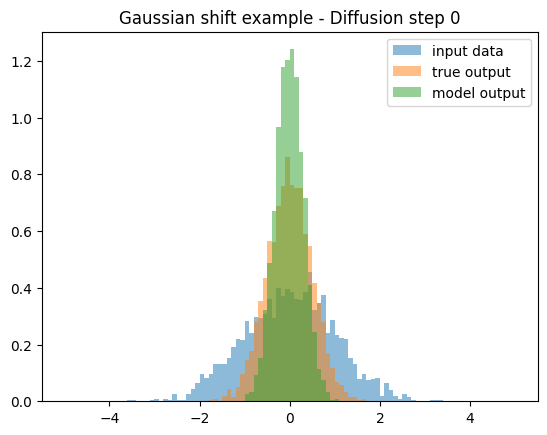

In [27]:
plt.hist(np.array(x_features).flatten(), 100, density = True, range = (-5, 5), alpha = 0.5, label = "input data")
plt.hist(np.array(y_features).flatten(), 100, density = True, range = (-5, 5), alpha = 0.5, label = "true output")
plt.hist(np.array(diffusion_model.diffused_inputs[0].features), 100, density = True, range = (-5, 5), alpha = 0.5, label = "model output")
plt.legend()
plt.title("Gaussian shift example - Diffusion step " + str(0))
plt.show()

In [ ]:
for i in range(len(diffusion_model.diffused_inputs)):
    plt.hist(np.array(x_features).flatten(), 100, density = True, range = (-5, 8), alpha = 0.5, label = "input data")
    plt.hist(np.array(y_features).flatten(), 100, density = True, range = (-5, 8), alpha = 0.5, label = "true output")
    plt.hist(np.array(diffusion_model.diffused_inputs[i].features), 100, density = True, range = (-5, 8), alpha = 0.5, label = "model output")
    plt.legend()
    plt.title("Gaussian shift example - Diffusion step " + str(i))
    plt.savefig("plots/diffused_step_" + str(i) + '.jpg', dpi = 200, format = 'jpg')
    plt.clf()

In [24]:
for i in range(len(diffusion_model.diffused_inputs)):
    if True:#i % 10 == 0:
        plt.hist(np.array(x_features).flatten(), 100, density = True, range = (-3, 3), alpha = 0.5, label = "input data")
        plt.hist(np.array(y_features).flatten(), 100, density = True, range = (-3, 3), alpha = 0.5, label = "true output")
        plt.hist(np.array(diffusion_model.diffused_inputs[i].features), 100, density = True, range = (-3, 3), alpha = 0.5, label = "model output")
        plt.legend()
        plt.ylim((0, 3.))
        plt.title("Gaussian shift example - Diffusion step " + str(i))
        plt.savefig("plots13/diffused_step_" + str(i) + '.jpg', dpi = 200, format = 'jpg')
        plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
"""fig, ax = plt.subplots()
xdata = []
ax.hist(np.array(x_features).flatten(), 100, density = True, range = (-5, 10), alpha = 0.5, label = "input data")
ax.hist(np.array(y_features).flatten(), 100, density = True, range = (-5, 10), alpha = 0.5, label = "true output")
ln = ax.hist([], 100, density = True, range = (-5, 10), alpha = 0.5, label = "model output")"""

def init():
    ax.set_xlim(-5, 10)
    ax.set_ylim(0, 3)
    return ln

def prepare_animation(bar_container):
    def animate(frame_number):
        for i in range(len(bar_container.patches)):
            bar_container.datavalues[i] = np.array(diffusion_model.diffused_inputs[frame_number].features[i])
        return bar_container.patches
    return animate

fig, ax = plt.subplots()
#ax.hist(np.array(x_features).flatten(), 100, density = True, range = (-5, 10), alpha = 0.5, label = "input data")
#ax.hist(np.array(y_features).flatten(), 100, density = True, range = (-5, 10), alpha = 0.5, label = "true output")
_, _, bar_container = ax.hist(np.array(diffusion_model.diffused_inputs[-1].features), 100, density = True, range = (-5, 10), alpha = 0.5, label = "model output")
ax.set_ylim(top=10)

anim = FuncAnimation(fig, prepare_animation(bar_container), 100, repeat=True, blit=True, interval = 1000)
plt.show()

In [ ]:
anim.save('animations/animation.gif', writer='imagemagick', fps=20)